In [5]:
#uncomment the 2 lines after to install the package
#source("http://bioconductor.org/biocLite.R")
#biocLite("rhdf5")
library(rhdf5)
library(grid)
library(keras)
library(lattice)
library(ggplot2)
library(caret)

In [6]:
#============================
#Load and Preprocess the Data
#============================
data <- read.csv("letters.csv")
files <- array(data$file)
letters <- array(data$letter)
backgrounds <- array(data$background)

In [7]:
# Create tensors and targets
fname <- "LetterColorImages.h5"
f <- h5ls(fname)
tensors <- h5read(fname, "/images")
targets <- h5read(fname, "/labels")
tensors <- aperm(tensors, c(4, 3, 2, 1))
print ("Tensor shape:")
dim(tensors)
print ("Target shape:")
dim(targets)

[1] "Tensor shape:"


[1] 1650   32   32    3

[1] "Target shape:"


[1] 1650

In [8]:
# Normalize the tensors
tensors <- tensors / 255

[1] "Label:"


[1] "胁"

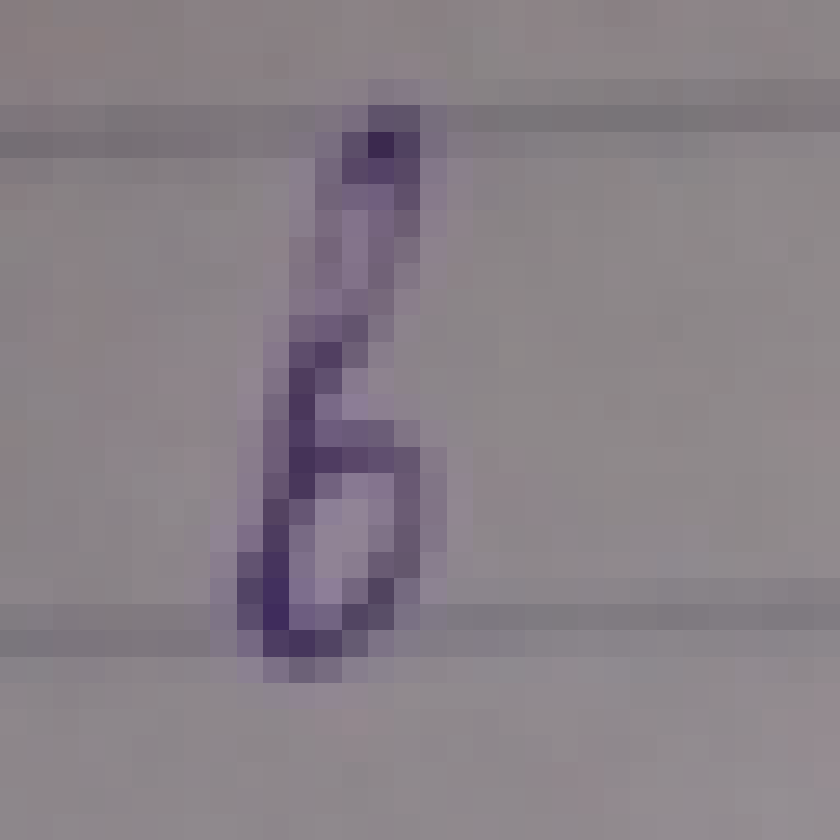

In [11]:
# Read and display a tensor
print("Label:")
letters[101]
col <-
  rgb(tensors[101, , 1:32, 1], tensors[101, , 1:32, 2], tensors[101, , 1:32, 3])
dim(col) <- dim(tensors[101, , , 1])
grid.raster(col, interpolate = FALSE)

In [12]:
# Grayscaled tensors
gray_tensors <- tensors
mean <- function(a) {
  return (a[1] * 0.299 + a[2] * 0.587 + a[3] * 0.114)
}
gray_tensors <- apply(gray_tensors, c(1, 2, 3), mean)
print ("Grayscaled Tensor shape:")
dim(gray_tensors)

[1] "Grayscaled Tensor shape:"


[1] 1650   32   32

[1] "Label:"


[1] "胁"

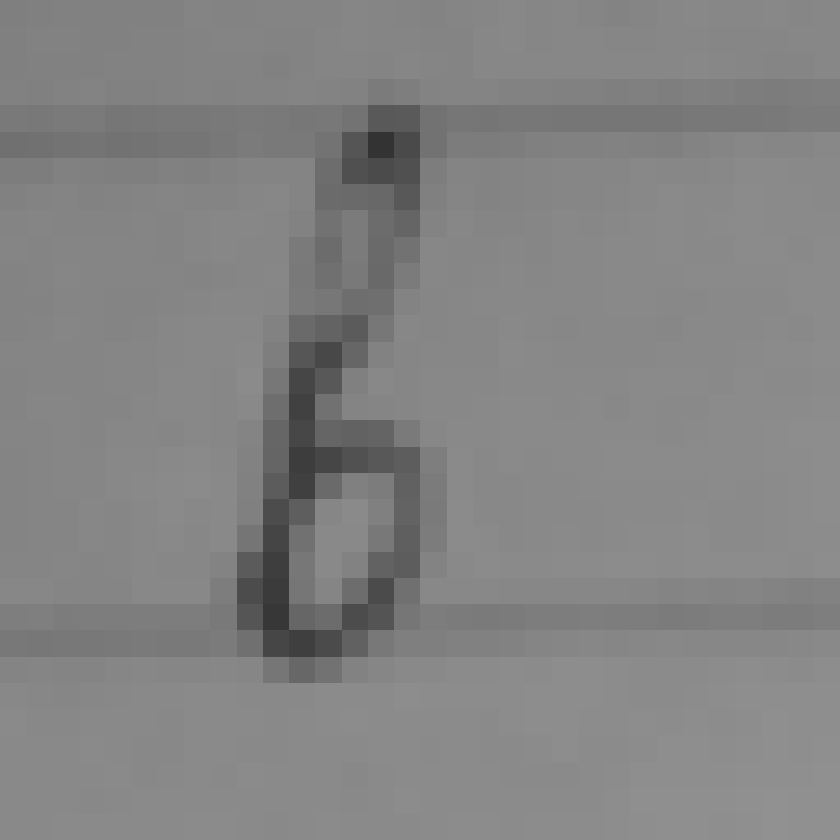

In [13]:
# Read and display a grayscaled tensor
print("Label:")
letters[101]
grid.raster(gray_tensors[101, , 1:32], interpolate = FALSE)

In [14]:
# Print the target unique values
unique(targets)
print("{а,б,в,г,д,е,ё,ж,з,и,й,к,л,м,н,о,п,р,с,т,у,ф,х,ц,ч,ш,щ,ъ,ы,ь,э,ю,я}")

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[26] 26 27 28 29 30 31 32 33

[1] "{а,б,в,г,д,е,ё,ж,з,и,й,к,л,м,н,о,п,р,с,т,у,ф,х,ц,ч,ш,щ,ъ,ы,ь,э,ю,я}"


In [18]:
# One-hot encode the targets, started from the zero label
cat_targets = to_categorical(targets - 1, 33)
dim(cat_targets)

[1] 1650   33

In [19]:
# Split the data
set.seed(100)
#creating indices
trainIndex <-
  createDataPartition(cat_targets[, 1], p = 0.8, list = FALSE)
x_train <- tensors[trainIndex, , ,]
y_train <- cat_targets[trainIndex,]
x_test <- tensors[-trainIndex, , ,]
y_test <- cat_targets[-trainIndex,]

In [20]:
# Print the shape
print ("Training tensor's shape:")
dim(x_train)
print ("Training target's shape:")
dim(y_train)
print ("Testing tensor's shape:")
dim(x_test)
print ("Testing target's shape:")
dim(y_test)

[1] "Training tensor's shape:"


[1] 1320   32   32    3

[1] "Training target's shape:"


[1] 1320   33

[1] "Testing tensor's shape:"


[1] 330  32  32   3

[1] "Testing target's shape:"


[1] 330  33

In [21]:
# Split the grayscaled data
trainIndex <-
  createDataPartition(cat_targets[, 1], p = 0.8, list = FALSE)
x_train2 <- gray_tensors[trainIndex, ,]
y_train2 <- cat_targets[trainIndex,]
x_test2 <- gray_tensors[-trainIndex, ,]
y_test2 <- cat_targets[-trainIndex,]
dim(trainIndex)
x_train2 <- array(x_train2, c(dim(trainIndex)[1], 32, 32, 1))
x_test2 <-
  array(x_test2, c(dim(gray_tensors)[1] - dim(-trainIndex)[1], 32, 32, 1))

[1] 1320    1

In [22]:
# Print the shape
print ("Training grayscaled tensor's shape:")
dim(x_train2)
print ("Training grayscaled target's shape:")
dim(y_train2)
print ("Testing grayscaled tensor's shape:")
dim(x_test2)
print ("Testing grayscaled target's shape:")
dim(y_test2)

[1] "Training grayscaled tensor's shape:"


[1] 1320   32   32    1

[1] "Training grayscaled target's shape:"


[1] 1320   33

[1] "Testing grayscaled tensor's shape:"


[1] 330  32  32   1

[1] "Testing grayscaled target's shape:"


[1] 330  33

In [27]:
#============================
#Create Classification Models
#============================
# create model
model <- keras_model_sequential()
# define and compile the model
model %>%
  layer_conv_2d(
    filters = 32,
    kernel_size = c(5, 5),
    padding = 'same',
    activation = 'relu',
    input_shape = dim(x_train)[2:4]
  ) %>%
  
  layer_max_pooling_2d(pool_size = c(2, 2)) %>%
  layer_dropout(rate = 0.25) %>%
  
  layer_conv_2d(filters = 128,
                kernel_size = c(5, 5),
                activation = 'relu') %>%
  
  layer_max_pooling_2d(pool_size = c(2, 2)) %>%
  layer_dropout(rate = 0.25) %>%
  
  layer_global_max_pooling_2d() %>%
  
  layer_dense(units = 1024, activation = 'relu') %>%
  layer_dropout(rate = 0.25) %>%
  
  layer_dense(units = 128, activation = 'relu') %>%
  layer_dropout(rate = 0.25) %>%
  
  layer_dense(units = 33, activation = 'softmax') %>%
  
  keras::compile(loss = 'categorical_crossentropy',
                 optimizer = 'adam',
                 metrics = c('accuracy'))

In [28]:
# train
history <- model %>%
  fit(
    x_train,
    y_train,
    epochs = 30,
    batch_size = 64,
    verbose = 2,
    validation_data = list(x_test, y_test)
  )

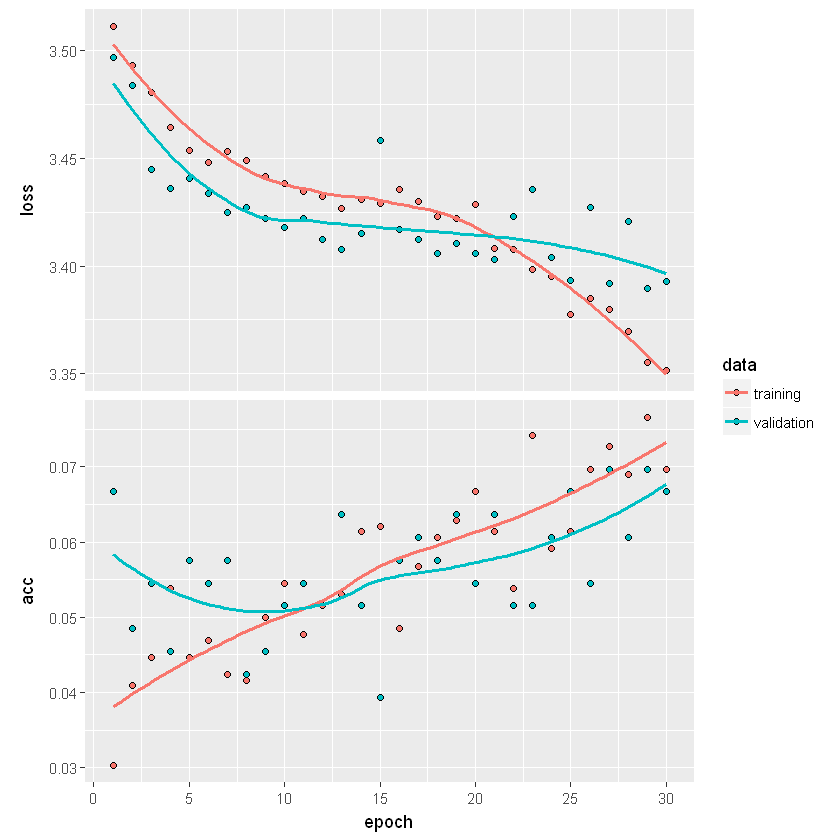

In [29]:
plot(history)

In [30]:
# Calculate classification accuracy on the testing set
score <- model %>% keras::evaluate(x_test, y_test)
score

$loss
[1] 3.392642

$acc
[1] 0.06666667

In [31]:
#Define a model architecture and compile the model for grayscaled images.
gray_model <- keras_model_sequential()
gray_model %>%
  layer_conv_2d(
    filters = 32,
    kernel_size = c(5, 5),
    padding = 'same',
    activation = 'relu',
    input_shape = dim(x_train2)[2:4]
  ) %>%
  layer_max_pooling_2d(pool_size = c(2, 2)) %>%
  layer_dropout(rate = 0.25) %>%
  
  layer_conv_2d(filters = 256,
                kernel_size = c(5, 5),
                activation = 'relu') %>%
  layer_max_pooling_2d(pool_size = c(2, 2)) %>%
  layer_dropout(rate = 0.25) %>%
  
  layer_global_max_pooling_2d() %>%
  
  layer_dense(units = 1024, activation = 'relu') %>%
  layer_dropout(rate = 0.25) %>%
  
  layer_dense(units = 256, activation = 'relu') %>%
  layer_dropout(rate = 0.25) %>%
  
  layer_dense(units = 33, activation = 'softmax') %>%
  
  keras::compile(loss = 'categorical_crossentropy',
                 optimizer = 'rmsprop',
                 metrics = c('accuracy'))

In [32]:
gray_history <- gray_model %>%
  fit(
    x_train2,
    y_train2,
    epochs = 100,
    batch_size = 64,
    verbose = 2,
    validation_data = list(x_test2, y_test2)
  )

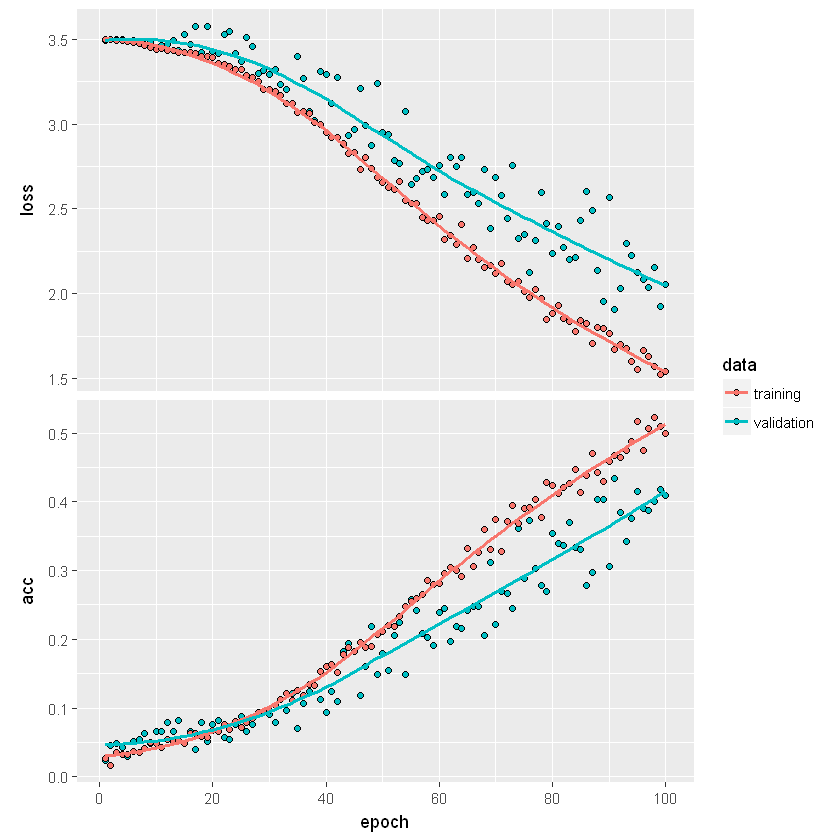

In [33]:
plot(gray_history)

In [34]:
gray_score  <-
  gray_model %>% keras::evaluate(x_test2, y_test2)
gray_score

$loss
[1] 2.051305

$acc
[1] 0.4090909

In [23]:
#========================
#Random Forest Classifier
#========================
library(reticulate)
use_python(Sys.which('python'))
use_virtualenv("myenv")
sklearn <- import("sklearn.ensemble")

In [24]:
y_train_c <- c()
for (i in 1:dim(y_train)[1]) {
  y_train_c <- c(y_train_c, which(y_train[i, ] == max(y_train[i, ])))
}
y_test_c <- c()
for (i in 1:dim(y_test)[1]) {
  y_test_c <- c(y_test_c, which(y_test[i, ] == max(y_test[i, ])))
}

In [26]:
x_train_r <- R.utils::wrap(x_train, map = list(1, NA))
x_test_r <- R.utils::wrap(x_test, map = list(1, NA))
clf <- sklearn$RandomForestClassifier()$fit(x_train_r, y_train_c)
clf$score(x_test_r, y_test_c)

[1] 0.1060606